### Libraries

In [31]:
# --------------------------------------------------------------
# System utilities
# --------------------------------------------------------------
import os  # Operating system interfaces

# --------------------------------------------------------------
# Data manipulation libraries
# --------------------------------------------------------------
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Support for large, multi-dimensional arrays and matrices

# --------------------------------------------------------------
# Data visualization libraries
# --------------------------------------------------------------
import matplotlib.pyplot as plt  # 2D plotting library
import seaborn as sns            # Statistical data visualization built on top of Matplotlib
import plotly.express as px      # Interactive visualizations for data exploration
import plotly.graph_objects as go  # Low-level interface for creating more complex Plotly visualizations
from plotly.subplots import make_subplots  # Create complex multi-plot visualizations

# --------------------------------------------------------------
# Machine learning models and preprocessing from scikit-learn
# --------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, LabelEncoder, StandardScaler  # Feature scaling and encoding methods
from sklearn.datasets import fetch_california_housing  # Sample dataset for regression tasks
from sklearn.model_selection import train_test_split  # Splitting datasets into training and test sets
from sklearn.linear_model import Lasso  # Lasso regression model

# --------------------------------------------------------------
# Libraries for handling imbalanced datasets
# --------------------------------------------------------------
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique for class imbalance


### Called Dataset

In [2]:
# Get the current working directory
directorio_actual = os.getcwd()

# Specify the relative path from the current directory
ruta_csv_relativa = os.path.join('..', 'data', '02_intermediate','2.spotifySinOutlier.csv')

# Load the CSV file
spotify = pd.read_csv(ruta_csv_relativa)

# Show the first rows of the DataFrame
spotify.head(10)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,log_popularity,log_duration_ms
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73.0,230666.0,False,0.676,0.4610,...,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,4.304065,12.348730
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55.0,149610.0,False,0.420,0.1660,...,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,4.025352,11.915794
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57.0,210826.0,False,0.438,0.3590,...,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,4.060443,12.258793
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71.0,201933.0,False,0.266,0.0596,...,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,4.276666,12.215696
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82.0,198853.0,False,0.618,0.4430,...,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,4.418841,12.200326
5,5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58.0,214240.0,False,0.688,0.4810,...,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic,4.077537,12.274857
6,6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74.0,229400.0,False,0.407,0.1470,...,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,4.317488,12.343227
7,7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80.0,242946.0,False,0.703,0.4440,...,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic,4.394449,12.400599
8,8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74.0,189613.0,False,0.625,0.4140,...,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic,4.317488,12.152746
9,9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56.0,205594.0,False,0.442,0.6320,...,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic,4.043051,12.233663


In [3]:
spotify.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,log_popularity,log_duration_ms
count,113799.000000,113799.000000,1.137990e+05,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000,113799.000000
mean,56945.195098,37.910931,2.281166e+05,0.567636,0.642113,5.309256,-8.238828,0.637484,0.084751,0.314660,0.155300,0.213242,0.474698,122.284671,3.909463,3.498402,12.265004
std,32890.531156,17.911576,1.063108e+05,0.172352,0.250775,3.559379,4.991810,0.480729,0.105758,0.332323,0.308837,0.189942,0.258815,29.601035,0.407795,0.685238,0.379915
min,0.000000,1.000000,1.580000e+04,0.051300,0.000020,0.000000,-46.591000,0.000000,0.022100,0.000000,0.000000,0.009250,0.000000,34.262000,0.000000,0.693147,9.667829
25%,28468.500000,26.000000,1.742000e+05,0.457000,0.473000,2.000000,-10.001000,0.000000,0.035900,0.016900,0.000000,0.098000,0.261000,99.408000,4.000000,3.295837,12.067965
50%,56927.000000,35.000000,2.130000e+05,0.580000,0.685000,5.000000,-6.998000,1.000000,0.048900,0.168000,0.000041,0.132000,0.464000,122.023000,4.000000,3.583519,12.269052
75%,85391.500000,50.000000,2.615870e+05,0.695000,0.854000,8.000000,-4.999000,1.000000,0.084600,0.597000,0.047500,0.273000,0.683000,140.072000,4.000000,3.931826,12.474526
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,211.945000,5.000000,4.615121,15.471316


## Data scaling

This scaling of variables is to be able to work with the models in the future.

### duration_ms Scaler

In [4]:
# Create a StandardScaler object
scaler = MinMaxScaler()

# Select only the popularity column to scale
spotify['duration_ms_scaled'] = scaler.fit_transform(spotify[['log_duration_ms']])

# Show first rows to check
spotify[['duration_ms', 'duration_ms_scaled']].head()

,duration_ms,duration_ms_scaled
0,230666.0,0.461947
1,149610.0,0.387347
2,210826.0,0.446450
3,201933.0,0.439024
4,198853.0,0.436375


### population Scaler

In [5]:
# Create a StandardScaler object
scaler = MinMaxScaler()

# Select only the popularity column to scale
spotify['popularity_scaled'] = scaler.fit_transform(spotify[['log_popularity']])

# Show first rows to check
spotify[['popularity', 'popularity_scaled']].head()

,popularity,popularity_scaled
0,73.0,0.920689
1,55.0,0.849624
2,57.0,0.858572
3,71.0,0.913703
4,82.0,0.949954


## Creating new features

### tranck_genre a Label Encoding

Change the categorical label of track_genre to a numeric value.

In [6]:
# Create the tag encoder
le = LabelEncoder()

# Apply Label Encoding to 'track_genre' column
spotify['track_genre_encoded'] = le.fit_transform(spotify['track_genre'])

# View the first rows to verify the encoding
spotify[['track_genre', 'track_genre_encoded']].head()

,track_genre,track_genre_encoded
0,acoustic,0
1,acoustic,0
2,acoustic,0
3,acoustic,0
4,acoustic,0


### New variable "intensity"

Having a good correlation thanks to the matrix, we decided to choose to combine energy with danceability

In [7]:
# Create a new "intensity" column
spotify['intensity'] = spotify['energy'] * spotify['danceability']
spotify['intensity'].head(10)

0    0.311636
1    0.069720
2    0.157242
3    0.015854
4    0.273774
5    0.330928
6    0.059829
7    0.312132
8    0.258750
9    0.279344
Name: intensity, dtype: float64

# Standardisation and scaling

### Histogram features_to_standardisation

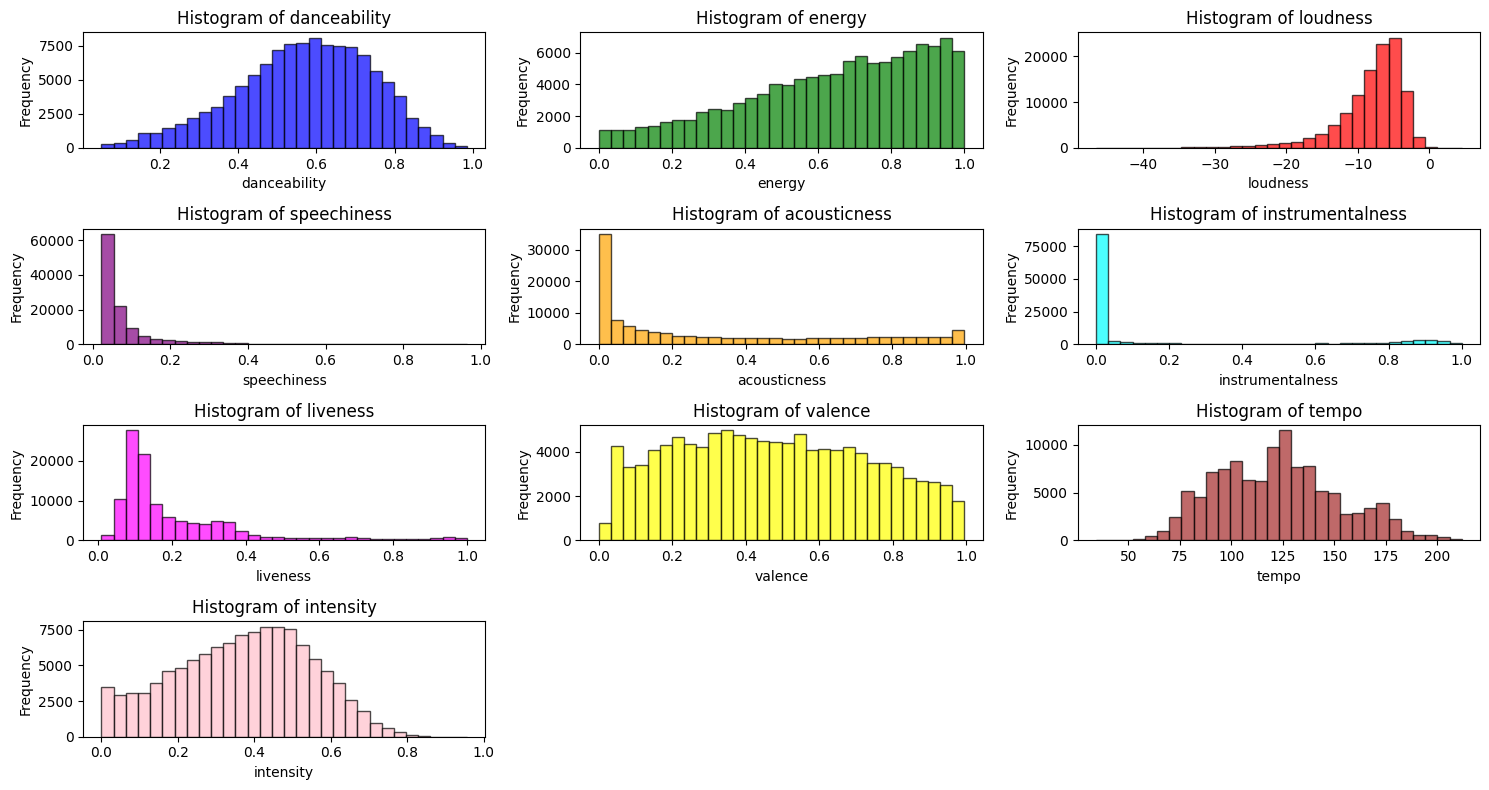

In [8]:
# Characteristics for standardisation
features_to_standardisation = ['danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 
                     'tempo','intensity']

# List color
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Create histograms for the selected features
plt.figure(figsize=(15, 8))
for i, (feature, color) in enumerate(zip(features_to_standardisation, colors)):
    plt.subplot(4, 3, i + 1)
    plt.hist(spotify[feature], bins=30, alpha=0.7, color=color, edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Distribution and Transformation Actions

The feature distributions and the adjustments needed to scale and normalize them for improved machine learning performance are briefly examined in this section. 

## Log Transformation
Features that are heavily skewed require a **log transformation** to reduce skewness and normalize their distribution:

- **speechiness**
- **acousticness**
- **instrumentalness**
- **liveness**

### Transformation:
Apply **log transformation** followed by **MinMaxScaler** to these features.

## Loudness - Quantile Transformation
- **loudness**: The values are skewed and contain negative numbers.

### Transformation:
Use **Quantile Transformer** to normalize the distribution, followed by **MinMaxScaler** to scale the values.

## MinMax Scaling
The following features are well distributed but require scaling to optimize model performance:

- **danceability**
- **energy**
- **valence**
- **tempo**

### Transformation:
These changes will guarantee that the data is appropriately scaled for machine learning models and enhance feature distributions.



### Logarithmic Transformation - MinMaxScaler

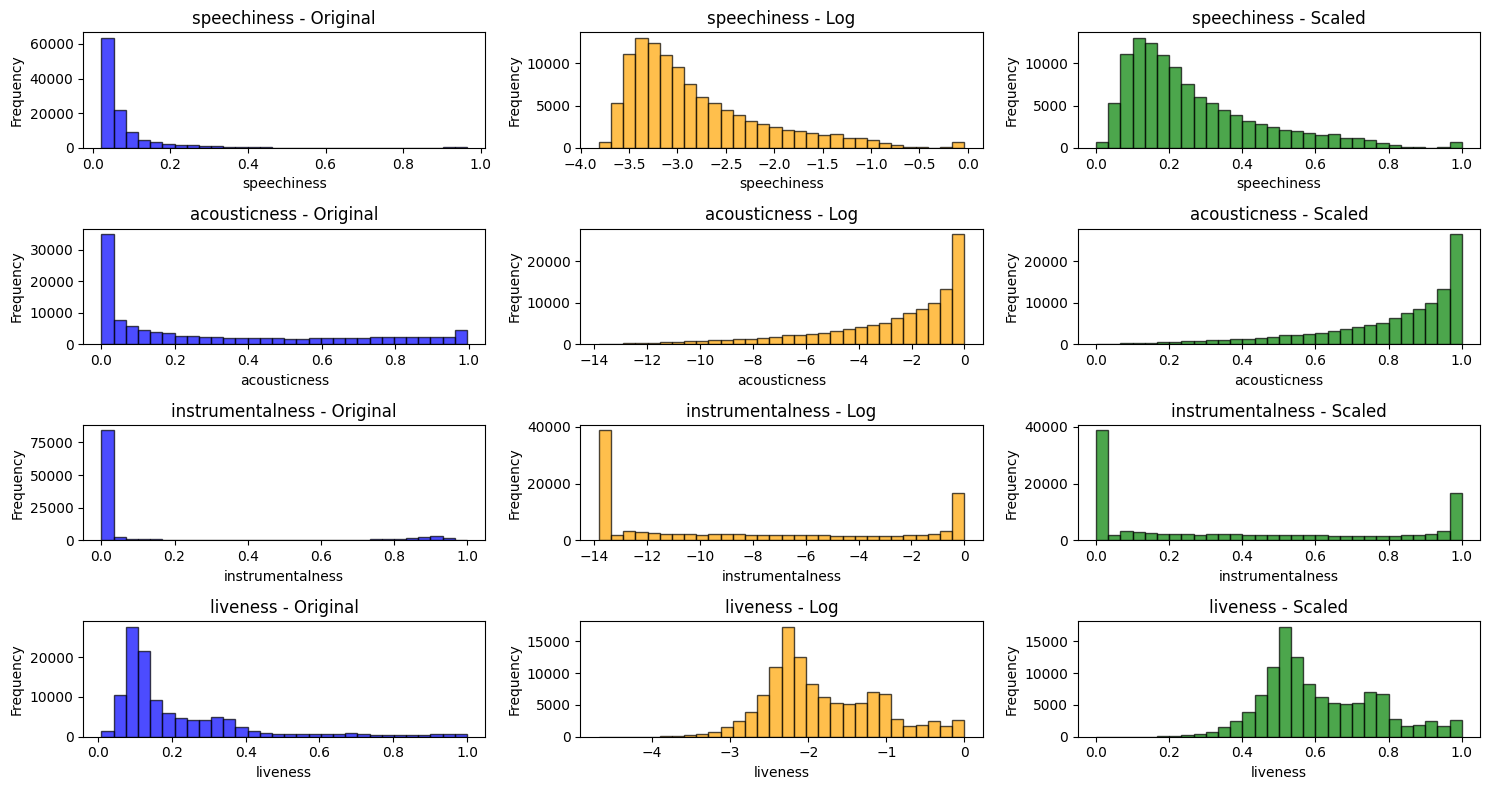

In [9]:
# Features to be transformed
features_log = ['speechiness', 'acousticness', 'instrumentalness', 'liveness']

# 1. Keep the original values for comparison later
spotify_original = spotify[features_log].copy()

# 2. Apply logarithmic transformation to the selected features
for feature in features_log:
    spotify[feature] = np.log(spotify[feature] + 1e-6)  # Avoid log(0) in the columns

# Save the logarithmically transformed values for comparison
spotify_log = spotify[features_log].copy()

# 3. Apply MinMaxScaler to the columns after the logarithmic transformation
scaler = MinMaxScaler()
spotify_scaled = pd.DataFrame(scaler.fit_transform(spotify[features_log]), columns=features_log)

# Rename the columns to avoid collisions with the original names
spotify_log.columns = [f'{col}_log' for col in features_log]
spotify_scaled.columns = [f'{col}_scaled' for col in features_log]

# 4. Concatenate the logarithmic and scaled columns to the original DataFrame
spotify = pd.concat([spotify, spotify_log, spotify_scaled], axis=1)

# 5. Compare histograms of original, log-transformed, and scaled data
plt.figure(figsize=(15, 8))

for i, feature in enumerate(features_log):
    # Histogram of the original values
    plt.subplot(len(features_log), 3, i*3 + 1)
    plt.hist(spotify_original[feature], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{feature} - Original')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Histogram of the logarithmic values
    plt.subplot(len(features_log), 3, i*3 + 2)
    plt.hist(spotify_log[f'{feature}_log'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.title(f'{feature} - Log')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Histogram of the scaled values
    plt.subplot(len(features_log), 3, i*3 + 3)
    plt.hist(spotify_scaled[f'{feature}_scaled'], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.title(f'{feature} - Scaled')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Transform Quantile

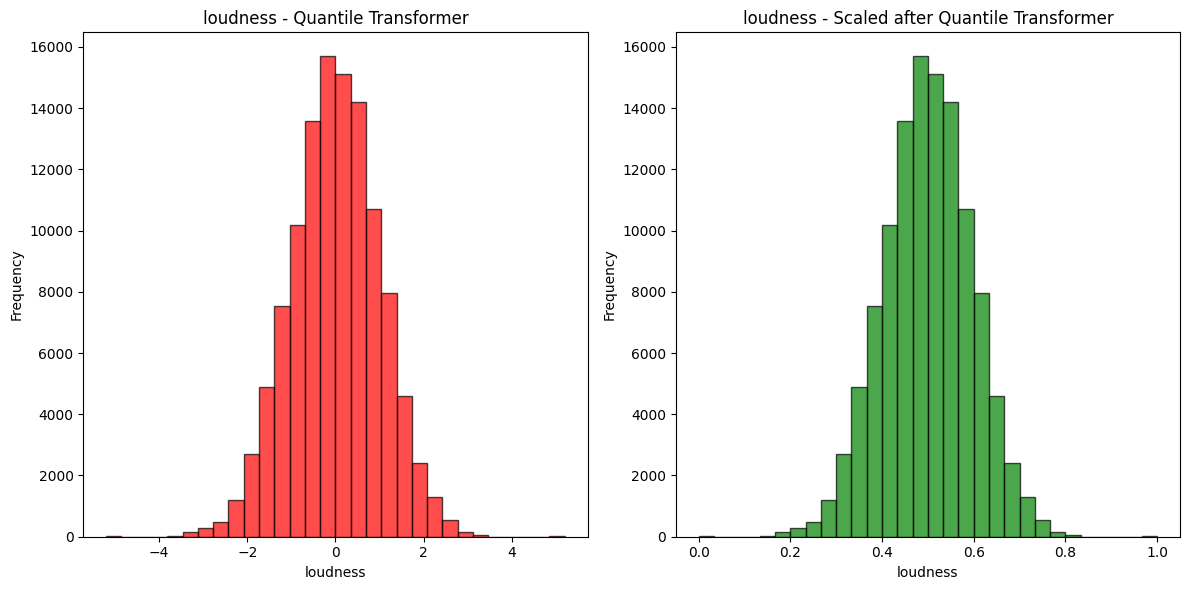

In [10]:
# 1. Shift the values to positive
spotify['loudness_positive'] = spotify['loudness'] + abs(spotify['loudness'].min()) + 0.001

# 2. Apply Quantile Transformer (normalizes to a normal distribution)
quantile_transformer = QuantileTransformer(output_distribution='normal')
spotify['loudness_quantile'] = quantile_transformer.fit_transform(spotify[['loudness_positive']])

# 3. Apply MinMaxScaler to scale the data to the range [0, 1]
scaler = MinMaxScaler()
spotify['loudness_scaled'] = scaler.fit_transform(spotify[['loudness_quantile']])

# Compare the histograms: Quantile Transform and then MinMaxScaler
plt.figure(figsize=(12, 6))

# Histogram of the values after the Quantile Transformer
plt.subplot(1, 2, 1)
plt.hist(spotify['loudness_quantile'], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('loudness - Quantile Transformer')
plt.xlabel('loudness')
plt.ylabel('Frequency')

# Histogram of the values after MinMaxScaler
plt.subplot(1, 2, 2)
plt.hist(spotify['loudness_scaled'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('loudness - Scaled after Quantile Transformer')
plt.xlabel('loudness')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### MinMaxScaler

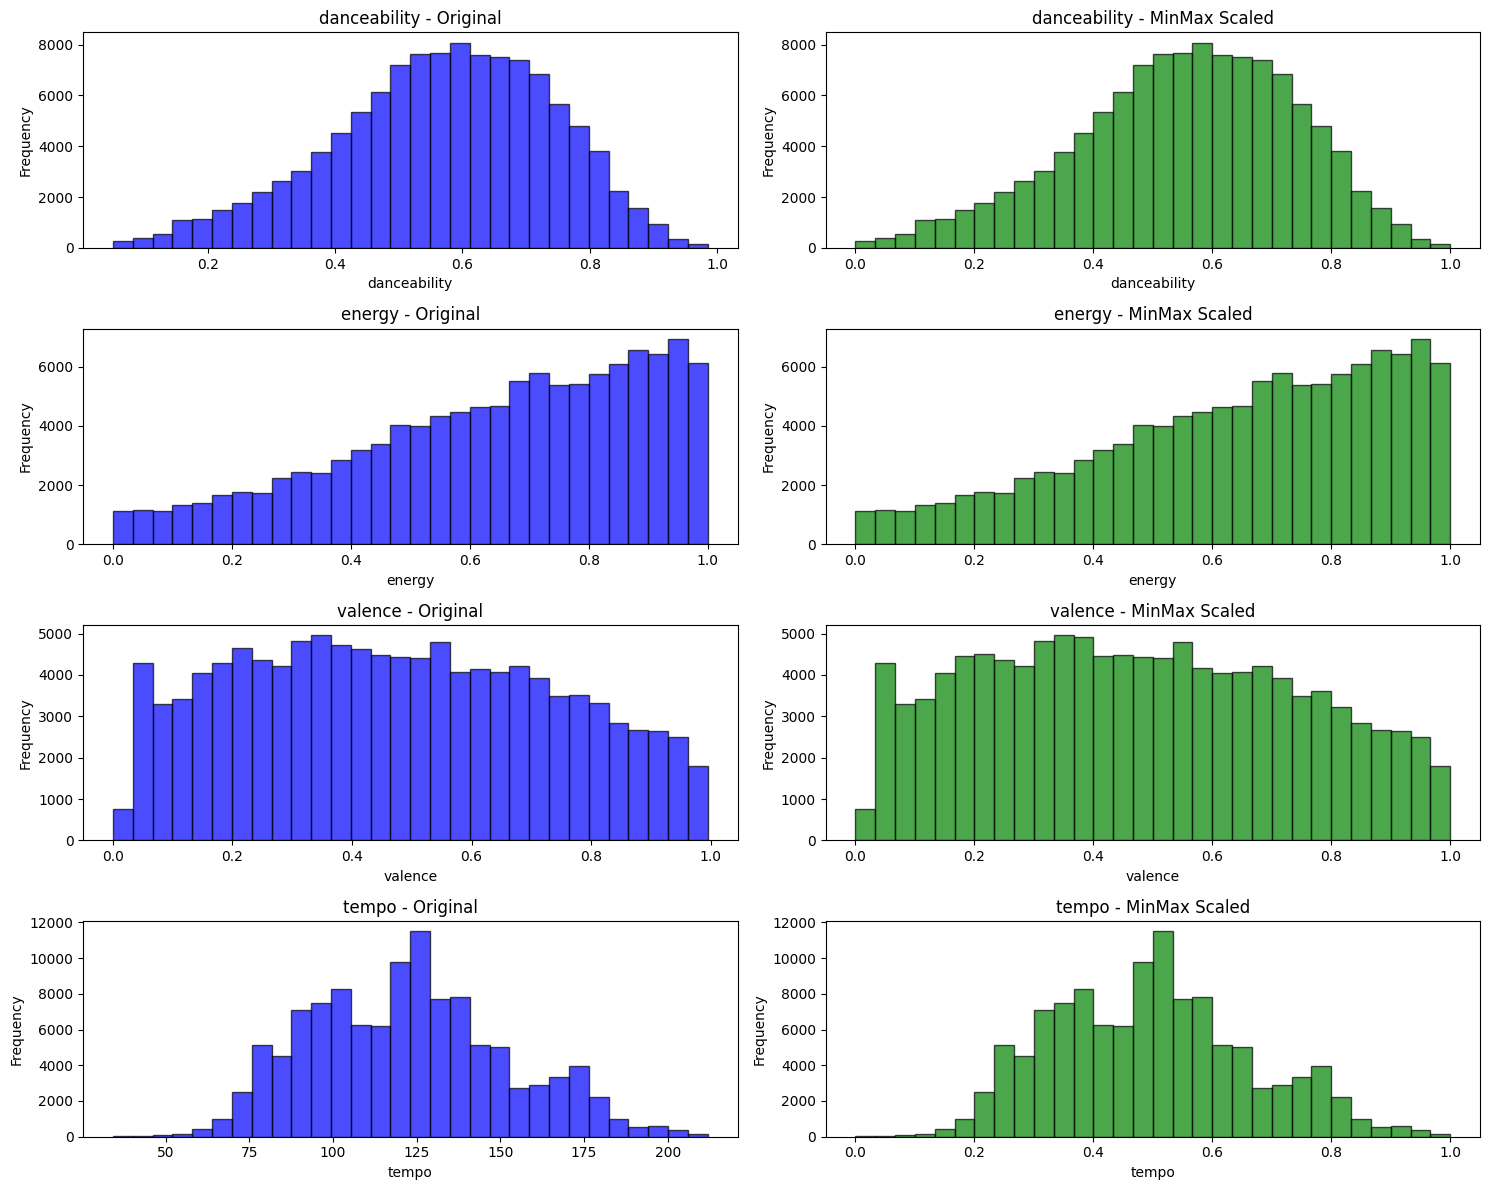

In [11]:
# Define the features to be scaled
features_scalers = ['danceability', 'energy', 'valence', 'tempo']

# 1. Apply MinMaxScaler to 'danceability', 'energy', 'valence', and 'tempo'
scaler_minmax = MinMaxScaler()
spotify_minmax_scaled = pd.DataFrame(scaler_minmax.fit_transform(spotify[features_scalers]), 
                                     columns=[f'{col}_scaled' for col in features_scalers])

# 2. Concatenate the transformations with the original DataFrame
spotify = pd.concat([spotify, spotify_minmax_scaled], axis=1)

# 3. Show an example comparing the original and MinMaxScaled values
plt.figure(figsize=(15, 12))

for i, feature in enumerate(features_scalers):
    # Histogram of the original values
    plt.subplot(len(features_scalers), 2, i*2 + 1)
    plt.hist(spotify[feature], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{feature} - Original')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Histogram of the scaled values (MinMaxScaler)
    plt.subplot(len(features_scalers), 2, i*2 + 2)
    plt.hist(spotify_minmax_scaled[f'{feature}_scaled'], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.title(f'{feature} - MinMax Scaled')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Target Exploration

C:\Users\Juako\Programación\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Juako\Programación\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Juako\Programación\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


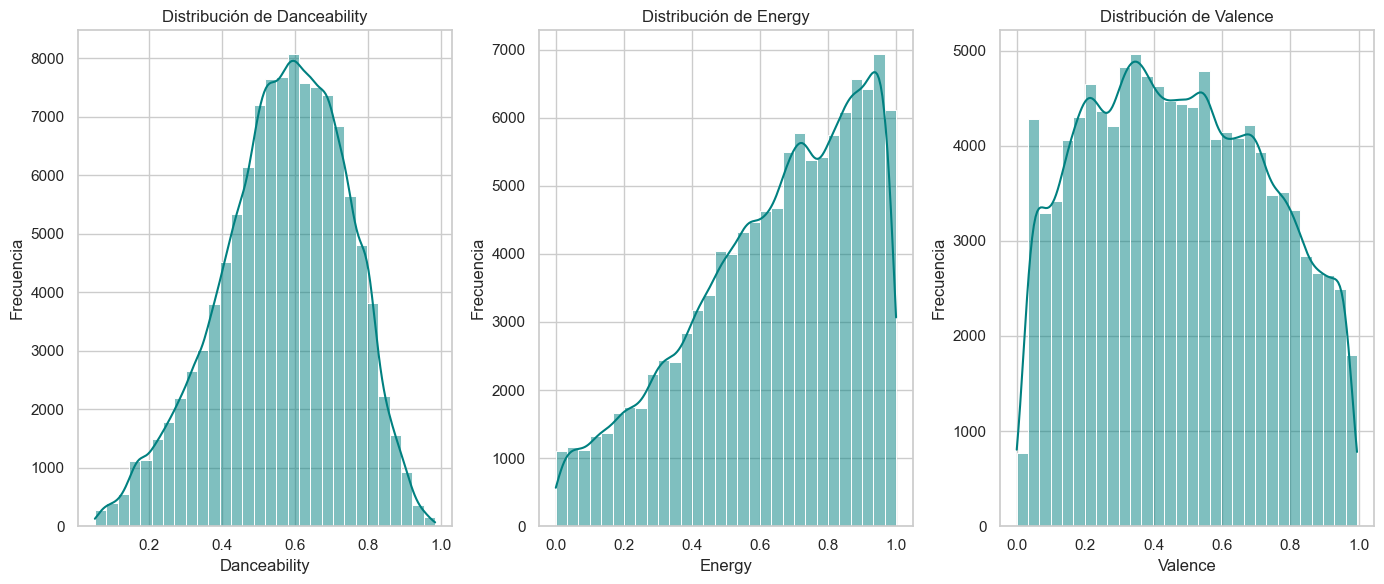

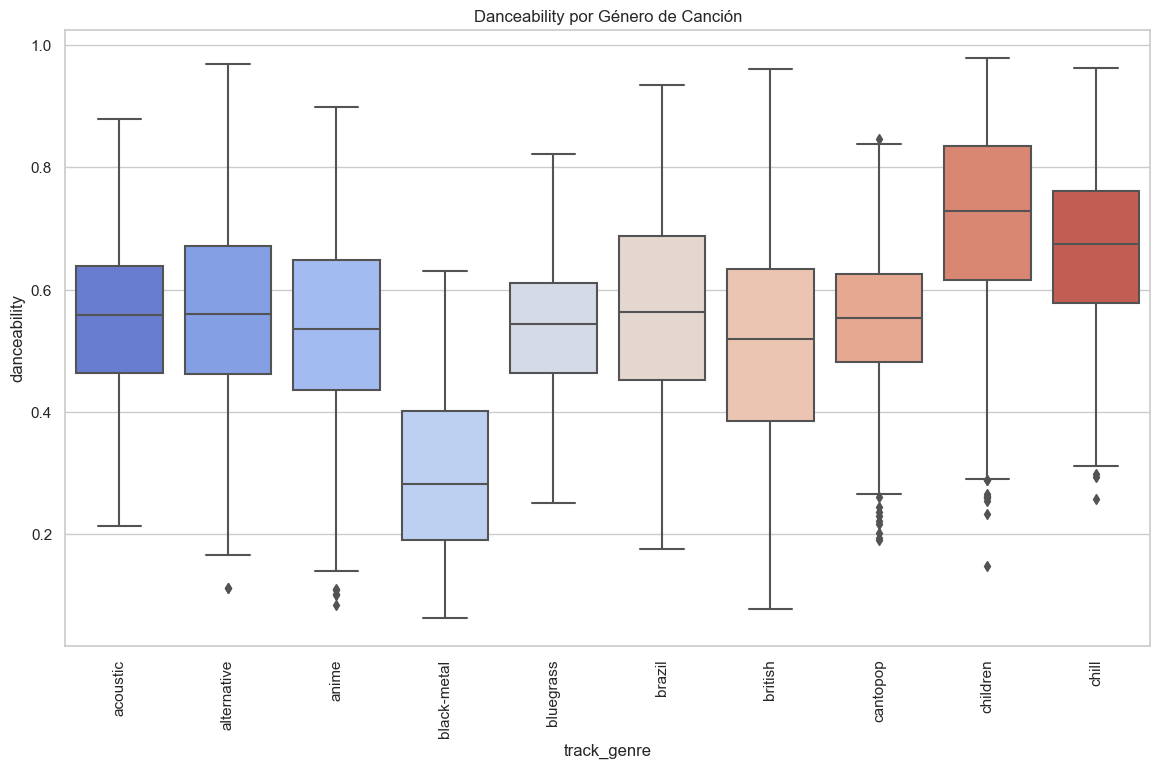

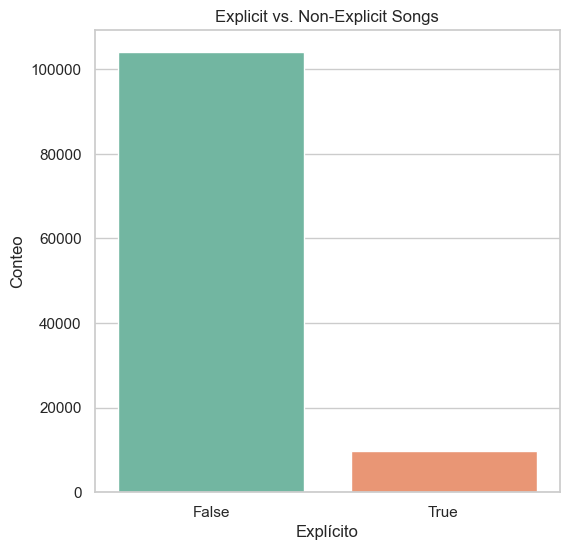

In [12]:
# Replace infinite values with NaN throughout the DataFrame
spotify.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
# Set graphics style
sns.set(style="whitegrid")
#1. Distribution of characteristics that affect recommendations (danceability, energy, valence)
plt.figure(figsize=(14,6))
# Subplots for each feature
for i, feature in enumerate(['danceability', 'energy', 'valence'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(spotify[feature].dropna(), bins=30, kde=True, color='teal')
    plt.title(f'Distribución de {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()
# 2. Relationship between Gender and characteristics for recommendations
plt.figure(figsize=(14,8))
top_genres = spotify['track_genre'].value_counts().nlargest(10) #Top 10 genres
sns.boxplot(x='track_genre', y='danceability', data=spotify[spotify['track_genre'].isin(top_genres.index)].dropna(), palette='coolwarm')
plt.title('Danceability por Género de Canción')
plt.xticks(rotation=90)
plt.show()
#3. Explicit Song Count
plt.figure(figsize=(6,6))
sns.countplot(x='explicit', data=spotify, palette='Set2')
plt.title('Explicit vs. Non-Explicit Songs')
plt.xlabel('Explícito')
plt.ylabel('Conteo')
plt.show()

### Histogram Chart Explanation
Danceability Distribution: The image represents a bell shape, meaning that most songs are danceable, suggesting that it does not greatly affect this field when recommending songs for the user who varies in tastes. Energy Distribution: The graph represents it with values skewed to the right side, meaning that the vast majority of songs have high energy, meaning that if a user opts for 'x' song, it is most likely that the recommendation should be with similar or equal energy levels. Valence Distribution: A uniform distribution,
suggesting that the mix of songs has a high and low positivity, but where the concentration of these values is in the middle of the graph. In summary, the feeling or atmosphere of the songs is mostly related to these three fields where the variability of the values is almost zero, allowing the
song search for the user to be successful most of the time, because no distribution graphs with atypical values were found, but rather, their results are generally close and therefore, successful. Danceability boxplot by song genre: The following graph shows the
relationships of the music genres, where it is highlighted that each box shows the distribution of the Danceability field by music genre. As can be seen, genres such as 'Alt-Rock' and 'Afrobeat' have more danceable songs than genres such as 'ambient' or 'blues'. This helps us to recommend music genres
for the user based on their favorite songs, in this way we have the closest and the most distant genres. Number of songs with explicit and non-explicit lyrics: As you can see, the number of non-explicit songs is around 100,000 songs, compared to songs that do contain explicit lyrics, where the value is around 8,000 to 10,000 songs. This option is crucial for song recommendations, since if the user chooses songs with explicit lyrics, the number of recommendations drops drastically compared to choosing songs without explicit lyrics, although it also gives the option to choose from both options. This is accompanied by business question 3, which shows us the exact number of songs with explicit lyrics by music genre. Conclusion: The graphs shown give us a broad resolution that covers themes of atmosphere or feelings that the songs deliver, similarity between music genres based on their danceability, and the number of songs with and without explicit lyrics. This will allow us to define in a more exact way the recommendations that we give to the user based on their tastes.

In [13]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113799 entries, 0 to 113798
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               113799 non-null  int64  
 1   track_id                 113799 non-null  object 
 2   artists                  113798 non-null  object 
 3   album_name               113798 non-null  object 
 4   track_name               113798 non-null  object 
 5   popularity               113799 non-null  float64
 6   duration_ms              113799 non-null  float64
 7   explicit                 113799 non-null  bool   
 8   danceability             113799 non-null  float64
 9   energy                   113799 non-null  float64
 10  key                      113799 non-null  int64  
 11  loudness                 113799 non-null  float64
 12  mode                     113799 non-null  int64  
 13  speechiness              113799 non-null  float64
 14  acou

In [14]:
spotify.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'log_popularity', 'log_duration_ms',
       'duration_ms_scaled', 'popularity_scaled', 'track_genre_encoded',
       'intensity', 'speechiness_log', 'acousticness_log',
       'instrumentalness_log', 'liveness_log', 'speechiness_scaled',
       'acousticness_scaled', 'instrumentalness_scaled', 'liveness_scaled',
       'loudness_positive', 'loudness_quantile', 'loudness_scaled',
       'danceability_scaled', 'energy_scaled', 'valence_scaled',
       'tempo_scaled'],
      dtype='object')

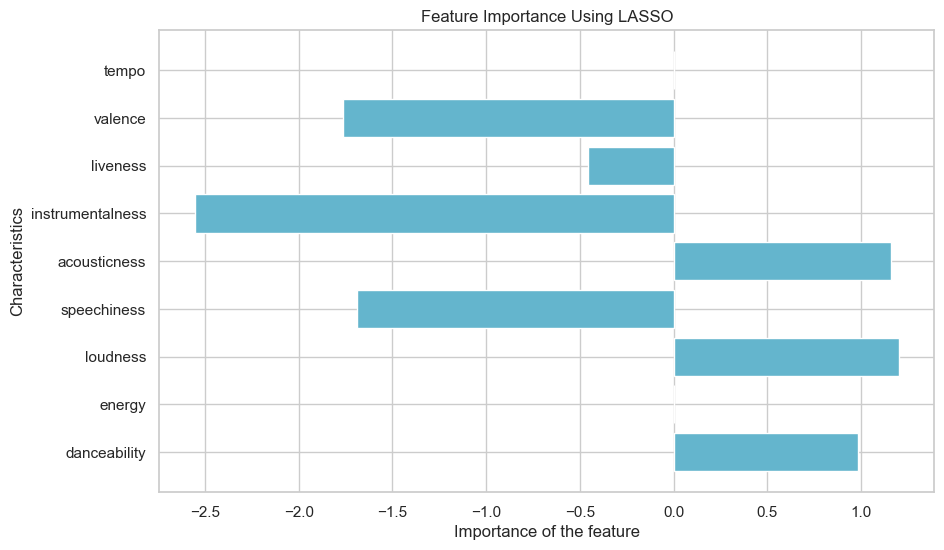

In [15]:
# We select the numerical features that we want to use for the regression
X = spotify[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
             'instrumentalness', 'liveness', 'valence', 'tempo']]  # Adjusts according to the available numeric columns

# Target column
y = spotify['popularity']

# Standardize the characteristics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the LASSO model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Get the coefficients (feature importance)
importancia = lasso.coef_

# Create a bar chart
caracteristicas = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                   'instrumentalness', 'liveness', 'valence', 'tempo']  # Your number columns
plt.figure(figsize=(10, 6))
plt.barh(caracteristicas, importancia, color='c')
plt.xlabel("Importance of the feature")
plt.ylabel("Characteristics")
plt.title("Feature Importance Using LASSO")
plt.show()

## Explanation
As you can see, using the LASSO method you can determine which are the most important variables of the Dataset (Target). As an observation, you can see the following:

1) The fields 'loudness' and 'danceability' have positive importance compared to the other fields, but in the case of 'loudness' its influence is less compared to the 'danceability' field.
2) Fields such as 'valance', 'liveness', 'instrumentalness', 'acousticness', 'speechiness' and 'energy' have negative importance, which means that for the search of the target field 'popularity', its influence is negative but noticeable.

Conclusion:

As an assessment, we can highlight 3 variables that influence the prediction of song popularity. Fields such as 'danceability' and 'loudness' have a minor but positive influence. On the other hand, the field that has the most influence is 'instrumentalness', which, being of negative impact, the higher the value of this characteristic, the worse its influence when predicting the target field. Therefore, it has been decided that these 3 fields are the most suitable for prediction, since they produce a greater influence compared to the other fields.

# Feature Removal

In [16]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113799 entries, 0 to 113798
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               113799 non-null  int64  
 1   track_id                 113799 non-null  object 
 2   artists                  113798 non-null  object 
 3   album_name               113798 non-null  object 
 4   track_name               113798 non-null  object 
 5   popularity               113799 non-null  float64
 6   duration_ms              113799 non-null  float64
 7   explicit                 113799 non-null  bool   
 8   danceability             113799 non-null  float64
 9   energy                   113799 non-null  float64
 10  key                      113799 non-null  int64  
 11  loudness                 113799 non-null  float64
 12  mode                     113799 non-null  int64  
 13  speechiness              113799 non-null  float64
 14  acou

### characteristics to be preserved. 
- duration_ms_scaled
- popularity_scaled
- speechiness_scaled
- acousticness_scaled
- instrumentalness_scaled
- liveness_scaled
- loudness_scaled
- danceability_scaled
- energy_scaled
- valence_scaled
- tempo_scaled
- track_genre
- track_genre_encoded
- intensity


In [24]:
# characteristics to be preserved
columns_to_keep = [
    'duration_ms_scaled',
    'popularity_scaled',
    'speechiness_scaled',
    'acousticness_scaled',
    'instrumentalness_scaled',
    'liveness_scaled',
    'loudness_scaled',
    'danceability_scaled',
    'energy_scaled',
    'valence_scaled',
    'tempo_scaled',
    'track_genre',
    'track_genre_encoded',
    'intensity'
]

# Select only those columns and discard the rest
spotify = spotify[columns_to_keep]

# Print the first rows to verify everything is correct
spotify.head()

,duration_ms_scaled,popularity_scaled,speechiness_scaled,acousticness_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,danceability_scaled,energy_scaled,valence_scaled,tempo_scaled,track_genre,track_genre_encoded,intensity
0,0.461947,0.920689,0.494433,0.751530,0.050533,0.780650,0.506999,0.669059,0.460989,0.718593,0.301970,acoustic,0,0.311636
1,0.387347,0.849624,0.328098,0.994567,0.136151,0.510439,0.344792,0.394881,0.165983,0.268342,0.243282,acoustic,0,0.069720
2,0.446450,0.858572,0.244770,0.887294,0.000000,0.541840,0.441037,0.414159,0.358987,0.120603,0.236770,acoustic,0,0.157242
3,0.439024,0.913703,0.131397,0.993063,0.309253,0.567599,0.336466,0.229945,0.059581,0.143719,0.830006,acoustic,0,0.015854
4,0.436375,0.949954,0.229607,0.945470,0.000000,0.468269,0.442250,0.606940,0.442989,0.167839,0.482246,acoustic,0,0.273774


## Exploration new DataSet "spotify"

## Correlation Matrix

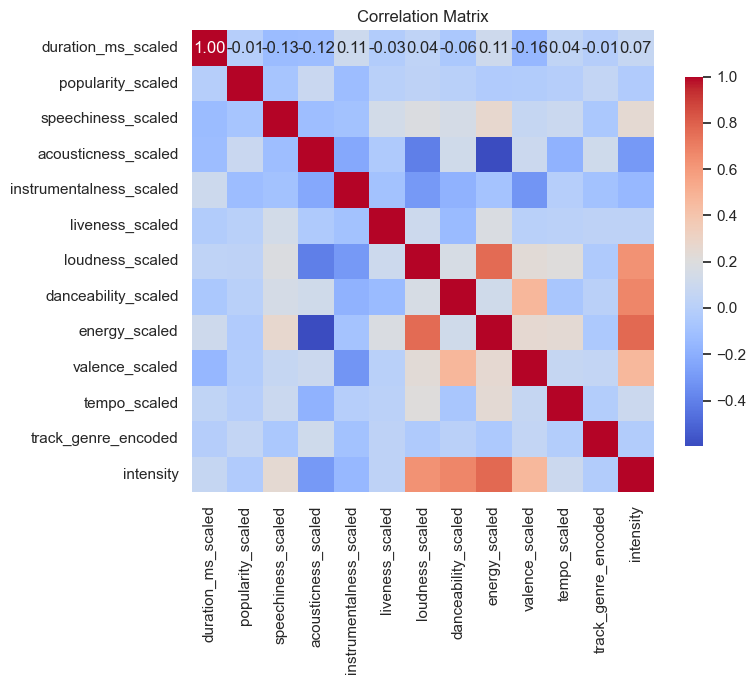

In [25]:
# Selection of Numeric Data
numeric_data = spotify.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix')
plt.show()

## Information of DataSet

In [27]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113799 entries, 0 to 113798
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_ms_scaled       113799 non-null  float64
 1   popularity_scaled        113799 non-null  float64
 2   speechiness_scaled       113799 non-null  float64
 3   acousticness_scaled      113799 non-null  float64
 4   instrumentalness_scaled  113799 non-null  float64
 5   liveness_scaled          113799 non-null  float64
 6   loudness_scaled          113799 non-null  float64
 7   danceability_scaled      113799 non-null  float64
 8   energy_scaled            113799 non-null  float64
 9   valence_scaled           113799 non-null  float64
 10  tempo_scaled             113799 non-null  float64
 11  track_genre              113799 non-null  object 
 12  track_genre_encoded      113799 non-null  int64  
 13  intensity                113799 non-null  float64
dtypes: f

## Total amount of data

In [28]:
spotify.dtypes.value_counts()

float64    12
object      1
int64       1
Name: count, dtype: int64

## Balance of the Objective with SMOTE

In [29]:
# Create the 'popularity_class' column in the original dataset
threshold = 0.75  # Threshold to define popularity
spotify['popularity_class'] = spotify['popularity_scaled'].apply(lambda x: 1 if x > threshold else 0)

# Convert categorical columns to dummy variables
spotify_encoded = pd.get_dummies(spotify, drop_first=True)

# Separate the features (X) and the target (y) with the encoded dataset
X = spotify_encoded.drop(columns=['popularity_class', 'popularity_scaled'])
y = spotify_encoded['popularity_class']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class balance
new_class_balance = y_resampled.value_counts(normalize=True)
print(new_class_balance)

# The original dataset now has the new 'popularity_class' column
spotify.head()  # Verify that the column has been added

popularity_class
1    0.5
0    0.5
Name: proportion, dtype: float64


,duration_ms_scaled,popularity_scaled,speechiness_scaled,acousticness_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,danceability_scaled,energy_scaled,valence_scaled,tempo_scaled,track_genre,track_genre_encoded,intensity,popularity_class
0,0.461947,0.920689,0.494433,0.751530,0.050533,0.780650,0.506999,0.669059,0.460989,0.718593,0.301970,acoustic,0,0.311636,1
1,0.387347,0.849624,0.328098,0.994567,0.136151,0.510439,0.344792,0.394881,0.165983,0.268342,0.243282,acoustic,0,0.069720,1
2,0.446450,0.858572,0.244770,0.887294,0.000000,0.541840,0.441037,0.414159,0.358987,0.120603,0.236770,acoustic,0,0.157242,1
3,0.439024,0.913703,0.131397,0.993063,0.309253,0.567599,0.336466,0.229945,0.059581,0.143719,0.830006,acoustic,0,0.015854,1
4,0.436375,0.949954,0.229607,0.945470,0.000000,0.468269,0.442250,0.606940,0.442989,0.167839,0.482246,acoustic,0,0.273774,1


# Futuro

El objetivo de este proyecto es desarrrollar un sistema de recomendación de música. Utilizando como target popularity_scaled y popularity_class ,ademas se usara K-Means y K-Vecinos más cercanos (K-NN). Hemos utilizado el procedimiento previo para preparar el conjunto de datos. 

- Escalado de variables: La mayoría de las variables numéricas han sido escaladas. Para asegurar que todas las características sean similares.
- Eliminación de variables categóricas: Las variables categóricas se han eliminado o transformado con el método de Label Encoding, para evitar problemas con los algoritmos que no puedan procesar ese tipo de dato.

El sistema de recomendación funcionará agrupando canciones similares (K-Means) o sugiriendo canciones basadas a las características (K-NN). De esta forma se busca que el sistema pueda recomendar canciones que se alineen con el gusto del usuario.
Cabe recalcar que el método para lograr el objetivo puede cambiar al avanzar con el desarrollo y evaluación de los modelos. Nuestra intención es buscar el mejor modelo para nuestro Recomendador. 

# Save DataSet

In [30]:
rute_cvs_save = os.path.join('..','data','03_primary','3.spotify.csv')
                             
spotify.to_csv (rute_cvs_save, index=False)